# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Modified Policy Iteration
- Implement Value Iteration
- Implement Gauss Seidel Value Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [ ]:
!pip install aicrowd-cli > /dev/null 

# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [ ]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")
API_KEY = "a98ef81b017008edad014f38a0bb30ae" # Get your key from https://www.aicrowd.com/participants/me

In [ ]:
!aicrowd login --api-key $API_KEY
!aicrowd dataset download -c iit-m-rl-assignment-2-taxi

API Key valid
Saved API Key successfully!
13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip: 100% 31.2k/31.2k [00:00<00:00, 221kB/s]


In [ ]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip
   creating: inputs/
  inflating: inputs/inputs_base.npy  
  inflating: inputs/inputs_1.npy     
  inflating: inputs/inputs_0.npy     
  inflating: inputs/inputs_2.npy     
   creating: targets/
  inflating: targets/targets_2.npy   
  inflating: targets/targets_0.npy   
  inflating: targets/targets_1.npy   
  inflating: targets/targets_base.npy  


In [ ]:
DATASET_DIR = 'inputs/'

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [ ]:
import numpy as np
from copy import deepcopy

class TaxiEnv_HW2:
    def __init__(self, states, actions, probabilities, rewards, initial_policy):
        self.possible_states = states
        self._possible_actions = {st: ac for st, ac in zip(states, actions)}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)

            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [ ]:
def check_taxienv():
    # These are the values as used in the pdf, but they may be changed during submission, so do not hardcode anything

    states = ['A', 'B', 'C']

    actions = [['1','2','3'], ['1','2'], ['1','2','3']]

    probs = [np.array([[1/2,  1/4,  1/4],
                    [1/16, 3/4,  3/16],
                    [1/4,  1/8,  5/8]]),

            np.array([[1/2,   0,     1/2],
                    [1/16,  7/8,  1/16]]),

            np.array([[1/4,  1/4,  1/2],
                    [1/8,  3/4,  1/8],
                    [3/4,  1/16, 3/16]]),]

    rewards = [np.array([[10,  4,  8],
                        [ 8,  2,  4],
                        [ 4,  6,  4]]),

            np.array([[14,  0, 18],
                        [ 8, 16,  8]]),

            np.array([[10,  2,  8],
                        [6,   4,  2],
                        [4,   0,  8]]),]
    initial_policy = {'A': '1', 'B': '1', 'C': '1'}

    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions('B'))
    print("Ride probabilities from state A with action 2", env.ride_probabilities('A', '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards('C', '3'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()
env = TaxiEnv_HW2(**base_kwargs)

All possible states ['A', 'B', 'C']
All possible actions from state B ['1', '2']
Ride probabilities from state A with action 2 [0.0625 0.75   0.1875]
Ride rewards from state C with action 3 [4 0 8]


## Task 1 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [ ]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf
    a = 0
    c = 0
    J = {}
    done = 0
    #while a < 1:
    while done == 0:
      done = 1
      #"""
      while True:
      #while c == 0:
        delta = deepcopy(np.NINF)
        val = {}
        for i in states:
          prob = deepcopy(taxienv.ride_probabilities(i, policy[i]))
          rew = deepcopy(taxienv.ride_rewards(i, policy[i]))
          J[i] = deepcopy(values[i])
          val[i] = deepcopy( sum([ (prob[states.index(j)])*( rew[states.index(j)] + gamma*values[j] ) for j in states ]) )
          delta = deepcopy( max(delta, np.abs(J[i]-val[i])) )
        for i in states:
          values[i] = deepcopy(val[i])
        #c = 1
        if delta < 1e-8:
          break
      #"""    


      val = {}
      b = {}
      #print("Hi0")
      for i in states:
        val2 = deepcopy(np.NINF)
        val1 = 0
        b[i] = deepcopy(policy[i])
        #print("Hi1")
        for j in taxienv.possible_actions(i):
          prob1 = deepcopy(taxienv.ride_probabilities(i, j))
          rew1 = deepcopy(taxienv.ride_rewards(i, j))
          val1 = deepcopy( sum([ (prob1[states.index(k)])*( rew1[states.index(k)] + gamma*values[k] ) for k in states ]) )
          #print("Hi2") 
          """if val2 == val1:
            #print("Hi3")
            continue """
          if val2 < val1:
            #print("hi5")
            policy[i] = deepcopy(j)
          val2 = deepcopy( max(val2, val1) )
          #print("Hi4")

        #print("Hi6")
        val[i] = deepcopy(val2)


        #a = a + 1

      for i in states:
        values[i] = deepcopy(val[i])
      for i in states:  
        if b[i] != policy[i]:
          done = 0


    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}
    extra_info["Expected Reward"] = values
    extra_info["Policy"] = policy

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 2 - Policy Iteration for multiple values of gamma

Ideally this code should run as is

In [ ]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

results, extra_info = run_policy_iteration(env)
gamma_values = np.arange(5, 100, 5)/100
for gamma in gamma_values:
  print("gamma :", gamma)
  print(results[gamma])

gamma : 0.05
{'Expected Reward': {'A': 8.511527294541914, 'B': 16.400259909012924, 'C': 7.498869066693811}, 'Policy': {'A': '1', 'B': '1', 'C': '1'}}
gamma : 0.1
{'Expected Reward': {'A': 9.076506149574659, 'B': 16.856368563583416, 'C': 8.050865123933633}, 'Policy': {'A': '1', 'B': '1', 'C': '1'}}
gamma : 0.15
{'Expected Reward': {'A': 9.708121493060538, 'B': 17.46450304254513, 'C': 8.6691604540995}, 'Policy': {'A': '1', 'B': '2', 'C': '1'}}
gamma : 0.2
{'Expected Reward': {'A': 10.437030074904103, 'B': 18.482142856858125, 'C': 9.384398495956734}, 'Policy': {'A': '1', 'B': '2', 'C': '1'}}
gamma : 0.25
{'Expected Reward': {'A': 11.274074073453669, 'B': 19.629629629008505, 'C': 10.207407406787004}, 'Policy': {'A': '1', 'B': '2', 'C': '1'}}
gamma : 0.3
{'Expected Reward': {'A': 12.243837243440458, 'B': 20.934065933669043, 'C': 11.162756162359376}, 'Policy': {'A': '1', 'B': '2', 'C': '1'}}
gamma : 0.35
{'Expected Reward': {'A': 13.378714435161033, 'B': 22.43076922968147, 'C': 12.2828240242

# Task 3 - Modifed Policy Iteration

Implement modified policy iteration (where Value iteration is done for fixed m number of steps)

In [ ]:
# 1.3 Modified Policy Iteration
def modified_policy_iteration(taxienv, gamma, m):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    
    # Put your extra information needed for plots etc in this dictionary

    a = 0
    c = 0
    J = {}
    done = 0
    #while a < 1:
    while done == 0:
      done = 1
      """
      for k in range(0,m):
      #while c == 0:
        delta = deepcopy(np.NINF)
        val = {}
        for i in states:
          prob = deepcopy(taxienv.ride_probabilities(i, policy[i]))
          rew = deepcopy(taxienv.ride_rewards(i, policy[i]))
          J[i] = deepcopy(values[i])
          val[i] = deepcopy( sum([ (prob[states.index(j)])*( rew[states.index(j)] + gamma*values[j] ) for j in states ]) )
          #delta = deepcopy( max(delta, np.abs(J[i]-val[i])) )
        for i in states:
          values[i] = deepcopy(val[i])
        #c = 1
        #if delta < 1e-8:
          #break
      """    

      for l in range(m):  
        delta = deepcopy(np.NINF)
        for i in states:
            prob1 = deepcopy(taxienv.ride_probabilities(i, policy[i]))
            rew1 = deepcopy(taxienv.ride_rewards(i, policy[i]))
            J[i] = deepcopy( sum([ (prob1[states.index(j)])*( rew1[states.index(j)] + gamma*values[j] ) for j in states ]) )

        for i in states:
          values[i] = deepcopy(J[i])
      
      val = {}
      b = {}
      #print("Hi0")
      for i in states:
        val2 = deepcopy(np.NINF)
        val1 = 0
        b[i] = deepcopy(policy[i])
        #print("Hi1")
        for j in taxienv.possible_actions(i):
          prob1 = deepcopy(taxienv.ride_probabilities(i, j))
          rew1 = deepcopy(taxienv.ride_rewards(i, j))
          val1 = deepcopy( sum([ (prob1[states.index(k)])*( rew1[states.index(k)] + gamma*values[k] ) for k in states ]) )
          #print("Hi2") 
          """if val2 == val1:
            #print("Hi3")
            continue """
          if val2 < val1:
            #print("hi5")
            policy[i] = deepcopy(j)
          val2 = deepcopy( max(val2, val1) )
          #print("Hi4")

        #print("Hi6")
        val[i] = deepcopy(val2)


        #a = a + 1

      for i in states:
        values[i] = deepcopy(val[i])
      for i in states:  
        if b[i] != policy[i]:
          done = 0



    
    
    extra_info = {}

    ## Do not edit below this line


    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 4 Modified policy iteration for multiple values of m

Ideally this code should run as is

In [ ]:
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

m_values = np.arange(1,15)
for m in m_values:
  print("m :", m)
  print(results[m])

m : 1
{'Expected Reward': {'A': 51.65324538936615, 'B': 65.3058853320694, 'C': 52.836659570999146}, 'Policy': {'A': '2', 'B': '2', 'C': '2'}}
m : 2
{'Expected Reward': {'A': 68.33458286289239, 'B': 81.98741862025872, 'C': 69.5180211304278}, 'Policy': {'A': '2', 'B': '2', 'C': '2'}}
m : 3
{'Expected Reward': {'A': 81.40917614736257, 'B': 95.06198699305824, 'C': 82.59260751614613}, 'Policy': {'A': '2', 'B': '2', 'C': '2'}}
m : 4
{'Expected Reward': {'A': 91.09772027266358, 'B': 104.75052562822177, 'C': 92.28115226304595}, 'Policy': {'A': '2', 'B': '2', 'C': '2'}}
m : 5
{'Expected Reward': {'A': 98.3983147469629, 'B': 112.05111925826964, 'C': 99.58174669738581}, 'Policy': {'A': '2', 'B': '2', 'C': '2'}}
m : 6
{'Expected Reward': {'A': 103.89548289701366, 'B': 117.54828731048154, 'C': 105.07891484980514}, 'Policy': {'A': '2', 'B': '2', 'C': '2'}}
m : 7
{'Expected Reward': {'A': 108.0493538262206, 'B': 121.702158228064, 'C': 109.23278577887602}, 'Policy': {'A': '2', 'B': '2', 'C': '2'}}
m :

# Task 5 Value Iteration

Implement value iteration and find the policy and expected rewards

In [ ]:
# 1.4 Value Iteration
def value_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf


    J = {}
    done = 1

    while True:  
      delta = deepcopy(np.NINF)
      for i in states:
        val = deepcopy(np.NINF)
        val1 = 0
        for j in taxienv.possible_actions(i):
          prob1 = deepcopy(taxienv.ride_probabilities(i, j))
          rew1 = deepcopy(taxienv.ride_rewards(i, j))
          val1 = deepcopy( sum([ (prob1[states.index(k)])*( rew1[states.index(k)] + gamma*values[k] ) for k in states ]) )
          
          if val < val1:
            policy[i] = deepcopy(j)
          val = deepcopy( max(val, val1) )

        J[i] = deepcopy(val)
        
        delta = deepcopy( max(delta, np.abs(J[i]-values[i])) )
      
      for i in states:
        values[i] = deepcopy(J[i])
      
      
      if delta < 1e-8:
        break
      

    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 6 Value Iteration with multiple values of gamma

Ideally this code should run as is

In [ ]:
def run_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = value_iteration(env, gamma)
    return results, extra_info
  
results, extra_info = run_value_iteration(env)

# Task 7 Gauss Seidel Value Iteration

Implement Gauss Seidel Value Iteration

In [ ]:
# 1.4 Gauss Seidel Value Iteration
def gauss_seidel_value_iteration(taxienv, gamma):
    # A list of all the states
    # For Gauss Seidel Value Iteration - iterate through the values in the same order
    states = taxienv.possible_states

    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    # Hints - 
    # Do not hardcode anything
    # For Gauss Seidel Value Iteration - iterate through the values in the same order as taxienv.possible_states
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ## Begin code here

    J = {}
    done = 1

    while True:  
      delta = deepcopy(np.NINF)
      for i in states:
        val = deepcopy(np.NINF)
        val1 = 0
        for j in taxienv.possible_actions(i):
          prob1 = deepcopy(taxienv.ride_probabilities(i, j))
          rew1 = deepcopy(taxienv.ride_rewards(i, j))
          J[i] = deepcopy(values[i])
          val1 = deepcopy( sum([ (prob1[states.index(k)])*( rew1[states.index(k)] + gamma*values[k] ) for k in states ]) )

          if val < val1:
            policy[i] = deepcopy(j)
          val = deepcopy( max(val, val1) )
        values[i] = deepcopy(val)
        
        delta = deepcopy( max(delta, np.abs(J[i]-values[i]))  )  
      
      if delta < 1e-8:
        break
      
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 8 Gauss Seidel Value Iteration with multiple values of gamma

Ideally this code should run as is

In [ ]:
def run_gauss_seidel_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = gauss_seidel_value_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_gauss_seidel_value_iteration(env)


# Generate Results ✅

In [ ]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]
    modified_policy_iteration_results = run_modified_policy_iteration(taxienv)[0]
    value_iteration_results = run_value_iteration(taxienv)[0]
    gs_vi_results = run_gauss_seidel_value_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["modifed_policy_iteration"] = modified_policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["gauss_seidel_iteration"] = gs_vi_results

    return final_results

In [ ]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your local score

This score is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [ ]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, rtol=3)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


## Visualize results of Policy Iteration with multiple values of gamma

Add code to visualize the results

In [ ]:
## Visualize policy iteration with multiple values of gamma
import pandas as pd
results, extra_info, Rewards, Policy = {}, {}, [], []
gamma_values = np.arange(5, 100, 5)/100
for gamma in gamma_values:
    results[gamma], extra_info = policy_iteration(env, gamma)
    Rewards.append(extra_info["Expected Reward"])
    Policy.append(extra_info["Policy"])


print("Optimal Value for each state for each gamma")
rew = pd.DataFrame(Rewards, index = [gamma for gamma in gamma_values])
print("\n")
print(rew)
print("\n")

print("Optimal Policy for each state for each gamma")
pol = pd.DataFrame(Policy, index = [gamma for gamma in gamma_values])
print("\n")
print(pol)





Optimal Value for each state for each gamma


               A           B           C
0.05    8.511527   16.400260    7.498869
0.10    9.076506   16.856369    8.050865
0.15    9.708121   17.464503    8.669160
0.20   10.437030   18.482143    9.384398
0.25   11.274074   19.629630   10.207407
0.30   12.243837   20.934066   11.162756
0.35   13.378714   22.430769   12.282824
0.40   14.722222   24.166667   13.611111
0.45   16.334131   26.205534   15.207371
0.50   18.298701   28.636364   17.155844
0.55   20.789989   31.607397   19.830725
0.60   24.025686   35.327724   23.458813
0.65   28.276692   40.096281   28.129979
0.70   34.061931   46.435416   34.366041
0.75   42.317411   55.285054   43.106317
0.80   55.079365   68.558201   56.269841
0.85   77.246512   90.811701   78.433456
0.90  121.653471  135.306275  122.836903
0.95  255.022908  268.764618  256.202849


Optimal Policy for each state for each gamma


      A  B  C
0.05  1  1  1
0.10  1  1  1
0.15  1  2  1
0.20  1  2  1
0.25  1  2  1
0

# Subjective questions


## 1.a How are values of $\gamma$ affecting results of policy iteration

For lower values of $\gamma$, the optimal values and policies favour the actions with higher rewards and doesnt capture much information from the previous state's values. Hence, the optimal values are lesser for lower $\gamma$ values.

Whereas from mid to higher values of $\gamma$, we can see that the optimal actions for all the states becomes the action $2$. This is because, for these values of $\gamma$ the current state's values depend more on the previous state's values as well as the the rewards for taking an action. Hence, we see an improvement of policy for all three states to {2,2,2}.

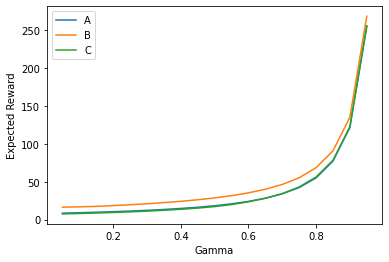

In [ ]:
import matplotlib.pyplot as plt
results, extra_info = run_policy_iteration(env)
gamma = list(results.keys())
for s in env.possible_states:
  J = []
  for i in gamma:
    J.append(results[i]["Expected Reward"][s])
  plt.plot(gamma, J)
plt.xlabel('Gamma')
plt.ylabel("Expected Reward")
plt.legend(env.possible_states)


## 1.b For modified policy iteration, do you find any improvement if you choose m=10.

When we choose m=10 we see an improvement in the expected reward beacuse it increases, but the optimal policy continues to be the same. 

## 1.c Compare and contrast the behavior of Value Iteration and Gauss Seidel Value Iteraton

Value Iteration takes more iterations to converge because it goes through all the states and then updates the values at the end. Whereas Gauss Siedel Value Iteration updates the values at the end of each state which helps in converge in lesser number of iteration because it uses information from the previous iteration on the states.

# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c iit-m-rl-assignment-2-taxi -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/Copy%20of%20IITM_Assignment_2_Taxi_Release.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7BtU533aeI6emMv0gSPBeWr9XEGA3AgcnWEuBIAd5Q-ycsGyLEW80
Mounted at /co